In [5]:
# dependency package import

import os

import math
import time
import random
from datetime import datetime
from pathlib import Path

from glob import glob

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

from PIL import Image
from tqdm.auto import tqdm

In [6]:
# 평가 이미지 리스트
BASE_DIR = '/data/kts123/aihub/reid'
test_imgs = '/data/kts123/aihub/reid/img_list_test.txt'

# 훈련된 모델경로
weight_path = '/home/kts123/gc2021/3차/track3/arcface/checkpoints_res50_base/scheduler_resnet50_99.pth'

/data/kts123/aihub/reid/val_imgs/OUT_H00001_SN1_207044_5600.png
eval_imgs/00000/OUT_H00001_SN1_207044_5600.png


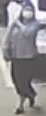

In [17]:
df = pd.read_csv(test_imgs)
for kls, df_i in df.groupby('KLS_IDX'):
    dst = f'eval_imgs/{kls:05d}'
    Path(dst).mkdir(exist_ok=True, parents=True)
    for name in df_i['NAME'].values:
        src = f'{BASE_DIR}/{name}'
        dst = f'{dst}/{Path(name).name}'
        break
    break
print(src)
print(dst)
Image.open(src)